# Goal

* Making cladogram for microbial genera (post-filtering)
* use heatmaps to plot phylogenetic signal
  * abundance of taxa in each host clade; ordered by cladograms

# Var

In [27]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/host_specific/clado_map/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq//physeq_SpecD.RDS'

# host cladogram
clado_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/cladogram//unified_metadata_20171206_r5k_Genus.nwk'

# misc
sparsity_cutoff = 0.3

# Init

In [28]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)
library(ape)
library(phyloseq)
source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 

In [29]:
make_dir(work_dir)
setwd(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/clado_map/ 


# Load

## physeq

In [30]:
physeq = readRDS(physeq_file)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19190 taxa and 131 samples ]
sample_data() Sample Data:       [ 131 samples by 100 sample variables ]
tax_table()   Taxonomy Table:    [ 19190 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19190 tips and 18939 internal nodes ]

### filter out no-genus designation

In [31]:
genera = physeq %>% tax_table %>% as.data.frame %>% .$Genus %>% unique %>% sort %>% as.vector
to_rm = c('unclassified', 'uncultured', 'unidentified', 'Incertae Sedis') 
to_rm = c(to_rm, genera[grepl('uncultured', genera)])
to_rm

[1] "unclassified"                               
 [2] "uncultured"                                 
 [3] "unidentified"                               
 [4] "Incertae Sedis"                             
 [5] "uncultured"                                 
 [6] "uncultured Acidimicrobidae bacterium"       
 [7] "uncultured actinobacterium"                 
 [8] "uncultured bacterium"                       
 [9] "uncultured Bacteroidales bacterium"         
[10] "uncultured Bacteroidetes bacterium"         
[11] "uncultured candidate division TG3 bacterium"
[12] "uncultured delta proteobacterium"           
[13] "uncultured Gemmata sp."                     
[14] "uncultured haloarchaeon"                    
[15] "uncultured organism"                        
[16] "uncultured Porphyromonadaceae bacterium"    
[17] "uncultured proteobacterium"                 
[18] "uncultured rumen bacterium"                 
[19] "uncultured soil bacterium"                  
[20] "uncultured Verrucomicrobia bacterium"

In [32]:
physeq = physeq %>% 
    subset_taxa(!Genus %in% to_rm)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 8418 taxa and 131 samples ]
sample_data() Sample Data:       [ 131 samples by 100 sample variables ]
tax_table()   Taxonomy Table:    [ 8418 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 8418 tips and 8341 internal nodes ]

In [33]:
metadata = physeq %>% 
    sample_data %>% 
    as.matrix %>% as.data.frame
metadata %>% status

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 131 100


,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subj_id,host_common_name,scientific_name,scientific_name_subspecies,⋯,PCR_dil_qPCR_2,Ct_A_2,Ct_B_2,Amount_SYBR_copies_in_5_ul_A_2,Amount_SYBR_copies_in_5_ul_B_2,Amount_geometric_mean_SYBR_2,Copies_in_5_ul_PCR_template_2,Copies_per_100_ul_extract_2,wellplate_Illumina,wellplate_position_Illumina
X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,1,Eurasian.Beaver,Castor fiber,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,2,B12
X109.Red.Fox,ACTGTCGAAGCT,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0057,109,109,Red.Fox,Vulpes vulpes,NA,⋯,16,15.01,NA,2.340E+7X,NA,NA,3.74e+08,7.49e+09,4,F2
X116.Common.Kestrel,ACACGGTGTCTA,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0011,116,116,Common.Kestrel,Falco tinnunculus,NA,⋯,16,20.79,NA,5.210E+5X,NA,NA,8.34e+06,1.67e+08,1,C11


### Summing by genus & filter sparse

In [35]:
# summing by genus
phyloseq_genus = phyloseq(otu_table(physeq),
                          sample_data(physeq),
                          tax_table(physeq))

physeq_genus = phyloseq_genus %>% 
    tax_glom('Genus') 
physeq_genus

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 533 taxa and 131 samples ]
sample_data() Sample Data:       [ 131 samples by 100 sample variables ]
tax_table()   Taxonomy Table:    [ 533 taxa by 7 taxonomic ranks ]

In [36]:
physeq_genus = physeq_genus %>%
    filter_taxa(function(x) sum(x > 0) / length(x) > sparsity_cutoff, TRUE) 
physeq_genus

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 22 taxa and 131 samples ]
sample_data() Sample Data:       [ 131 samples by 100 sample variables ]
tax_table()   Taxonomy Table:    [ 22 taxa by 7 taxonomic ranks ]

In [37]:
# free memory
physeq = NULL

In [38]:
physeq_genus_file = file.path(work_dir, 'physeq_IndD_genus.RDS')
saveRDS(physeq_genus, file=physeq_genus_file) 
cat('File written:', physeq_genus_file)

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/clado_map//physeq_IndD_genus.RDS

# Getting occurrance of genera in hosts

In [39]:
# otu format
otu = physeq_genus %>%
    otu_table %>%
    as.matrix %>%
    as.data.frame

otu$OTU = rownames(otu) 
rownames(otu) = 1:nrow(otu)
otu = otu %>%
    gather(sample, count, -OTU)
otu %>% status

[1] 2882    3


OTU,sample,count
0e1de44ae4fcc0968e549457277b4fb1,X1.Eurasian.Beaver,269
13fabb2c42c260bd77b4358f429eba6c,X1.Eurasian.Beaver,0
66702759d2d292afce742b8b989a6d1d,X1.Eurasian.Beaver,6


In [40]:
# adding taxonomy
tax = physeq_genus %>%
    tax_table %>%
    as.matrix %>%
    as.data.frame %>%
    dplyr::select(-Species)
tax$OTU = rownames(tax)
rownames(tax) = 1:nrow(tax)

# joining
otu = otu %>%
    inner_join(tax, c('OTU'='OTU'))

tax = NULL
otu %>% status

[1] 2882    9


OTU,sample,count,Domain,Phylum,Class,Order,Family,Genus
0e1de44ae4fcc0968e549457277b4fb1,X1.Eurasian.Beaver,269,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,Akkermansia
13fabb2c42c260bd77b4358f429eba6c,X1.Eurasian.Beaver,0,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Burkholderiaceae,Ralstonia
66702759d2d292afce742b8b989a6d1d,X1.Eurasian.Beaver,6,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Escherichia-Shigella


In [41]:
# adding host taxonomy
metadata = physeq_genus %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame %>%
    dplyr::select(class, order, family, genus)
metadata$SampleID = rownames(metadata) 
rownames(metadata) = 1:nrow(metadata)

# join
otu = otu %>%
    inner_join(metadata, c('sample'='SampleID'))

#metadata = NULL
otu %>% status

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 2882   13


OTU,sample,count,Domain,Phylum,Class,Order,Family,Genus,class,order,family,genus
0e1de44ae4fcc0968e549457277b4fb1,X1.Eurasian.Beaver,269,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,Akkermansia,Mammalia,Rodentia,Castoridae,Castor
13fabb2c42c260bd77b4358f429eba6c,X1.Eurasian.Beaver,0,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Burkholderiaceae,Ralstonia,Mammalia,Rodentia,Castoridae,Castor
66702759d2d292afce742b8b989a6d1d,X1.Eurasian.Beaver,6,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Escherichia-Shigella,Mammalia,Rodentia,Castoridae,Castor


### Summing by genus ~ genus

In [86]:
otu_s = otu %>%
    group_by(genus) %>%
    mutate(TOTAL_COUNT = sum(count)) %>%
    group_by(Domain, Phylum, Class, order, Family, Genus, genus) %>%
    summarize(count_raw = sum(count),
              count_perc = count_raw / first(TOTAL_COUNT) * 100) %>%
    ungroup() %>%
    arrange(Domain, Phylum, Class, order, Family, Genus)

otu_s %>% status 

[1] 2508    9


Domain,Phylum,Class,order,Family,Genus,genus,count_raw,count_perc
Bacteria,Bacteroidetes,Bacteroidia,Anseriformes,Bacteroidaceae,Bacteroides,Anas,0,0.000000
Bacteria,Bacteroidetes,Bacteroidia,Anseriformes,Bacteroidaceae,Bacteroides,Anser,222,6.271186
Bacteria,Bacteroidetes,Bacteroidia,Anseriformes,Bacteroidaceae,Bacteroides,Branta,0,0.000000


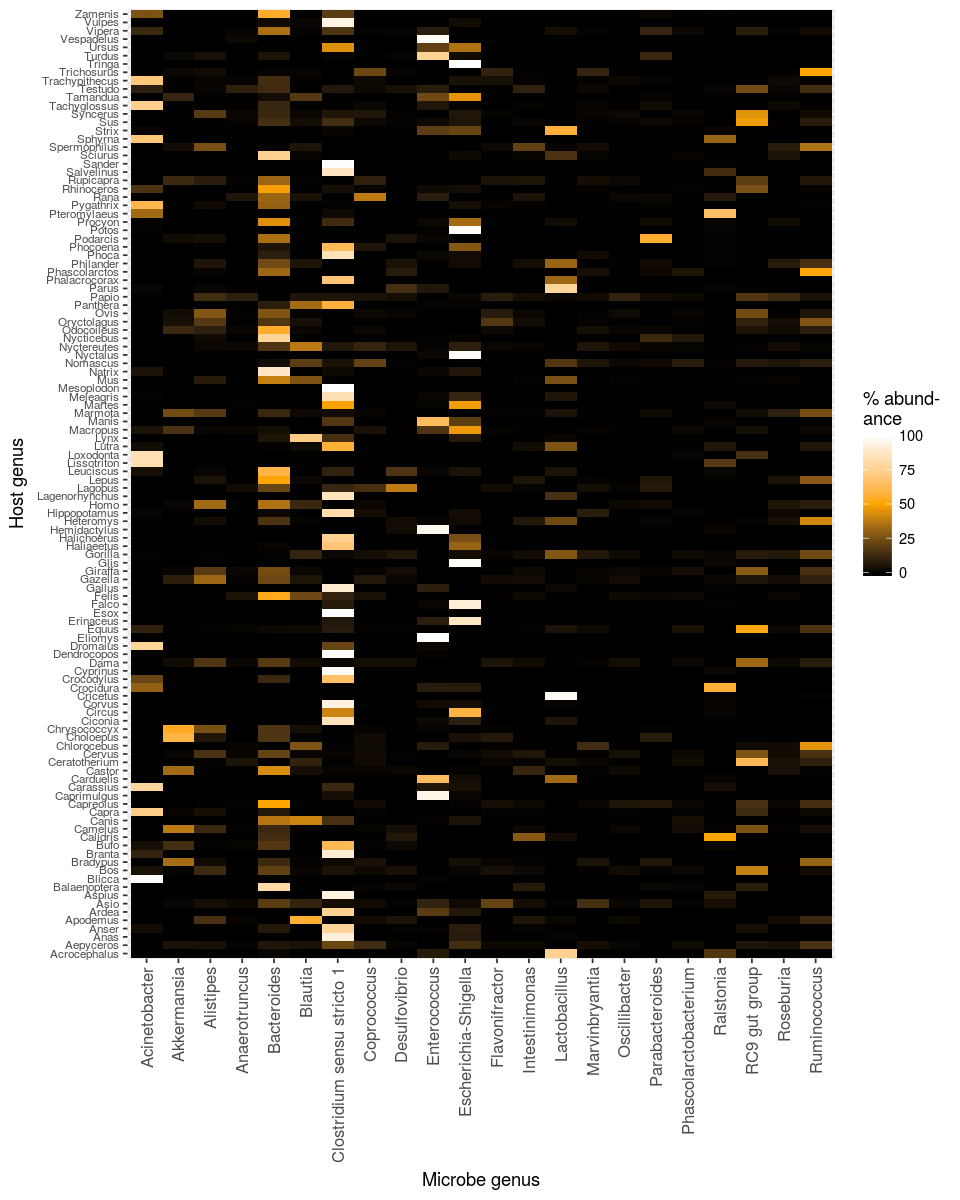

In [87]:
# plotting heatmap
p = ggplot(otu_s, aes(Genus, genus, fill=count_perc)) +
    geom_tile() +
    scale_fill_gradientn('% abund-\nance', colours=c('black', 'orange', 'white')) +
    labs(x='Microbe genus', y='Host genus') +
    theme(
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, size=10),
        axis.text.y = element_text(size=7)
    )
options(repr.plot.width=8, repr.plot.height=10)
plot(p)

# Formatting for iTOL

In [92]:
# ordering matrix
otu_s_m = otu_s %>%
    dplyr::select(Genus, genus, count_perc) %>%
    spread(Genus, count_perc) %>%
    as.data.frame

rownames(otu_s_m) = otu_s_m$genus
otu_s_m$genus = NULL

# reordering
otu_s_m = otu_s_m[,unique(otu_s$Genus)]

# status
otu_s_m %>% status

[1] 114  22


,Bacteroides,Parabacteroides,Alistipes,RC9 gut group,Enterococcus,Lactobacillus,Clostridium sensu stricto 1,Blautia,Coprococcus,Marvinbryantia,⋯,Flavonifractor,Intestinimonas,Oscillibacter,Ruminococcus,Phascolarctobacterium,Ralstonia,Desulfovibrio,Escherichia-Shigella,Acinetobacter,Akkermansia
Acrocephalus,1.041667,0,0.000000,0.00000,6.9444444,75.0000000,0.3472222,0.000000,0.00000,0.000000,⋯,0.000000,0.000000,0.000000,0.00000,0.000000,16.66667,0.0000000,0.000000,0.0000000,0.000000
Aepyceros,5.219780,0,3.571429,4.67033,0.0000000,0.0000000,21.9780220,4.120879,12.91209,3.021978,⋯,1.648352,1.648352,1.098901,15.10989,1.923077,0.00000,0.8241758,13.736264,0.2747253,4.120879
Anas,0.000000,0,0.000000,0.00000,0.1166861,0.7001167,91.9486581,0.000000,0.00000,0.000000,⋯,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.1166861,7.117853,0.0000000,0.000000


In [95]:
itol_htmp_file = file.path(work_dir, 'SpecD_genus-genus_htmp.txt')
labs = gsub(' ', '_', colnames(otu_s_m))
labs = sprintf('FIELD_LABELS %s\n', paste(labs, collapse=' '))

cat('DATASET_HEATMAP\n', file=itol_htmp_file)
cat('SEPARATOR SPACE\n', file=itol_htmp_file, append=TRUE)
cat('DATASET_LABEL genus abund.\n', file=itol_htmp_file, append=TRUE)
cat('COLOR #ff0000\n', file=itol_htmp_file, append=TRUE)
cat(labs, file=itol_htmp_file, append=TRUE)
cat('DATA\n', file=itol_htmp_file, append=TRUE)
write.table(otu_s_m, file=itol_htmp_file, append=TRUE, sep=' ', 
            quote=FALSE, col.names=FALSE)
cat('File written:', itol_htmp_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/clado_map//SpecD_genus-genus_htmp.txt 


In [96]:
system2(c('head', '-n 6', itol_htmp_file), stdout=TRUE) %>% print

[1] "DATASET_HEATMAP"                                                                                                                                                                                                                                                                                                                         
[2] "SEPARATOR SPACE"                                                                                                                                                                                                                                                                                                                         
[3] "DATASET_LABEL genus abund."                                                                                                                                                                                                                                                                                                          

# sessionInfo

In [97]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.3 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq_htmp/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq_htmp/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] bindrcpp_0.2    phyloseq_1.22.3 ape_5.0         stringr_1.2.0  
[5] ggplot2_2.2.1   tidyr_0.6.1     dplyr_0.7.4    

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.2-4        repr_0.10    

# -- OLD --

# Clado to dend conversion

In [ ]:
micro_dend = as.dendrogram(as.hclust(multi2di(micro_clado)))
host_dend = as.dendrogram(as.hclust(multi2di(host_clado)))

# Plotting heatmap

In [ ]:
library(ComplexHeatmap)

In [ ]:
otu_s_m = otu_s %>%
    dplyr::select(-count_raw) %>%
    spread(Genus, count_perc) %>%
    as.data.frame

rownames(otu_s_m) = otu_s_m$genus
otu_s_m$genus = NULL

otu_s_m %>% status

## Ordering by host clado

In [ ]:
m = otu_s_m %>% as.matrix
m = m[host_clado$tip,]
host_dend = as.dendrogram(as.hclust(multi2di(host_clado)))

options(repr.plot.width=8, repr.plot.height=10)
heatmap(otu_s_m %>% as.matrix, Rowv=host_dend, cexRow=0.4)

## Ordering by host-microbe clado

In [ ]:
# column annotation
tmp = tax_f %>%
    dplyr::select(Genus, Phylum)
rownames(tmp) = tmp$Genus
tmp = tmp[colnames(otu_s_m),'Phylum'] %>% as.data.frame
colnames(tmp) = c('Phylum')
ha_micro = HeatmapAnnotation(df=tmp)

options(repr.plot.width=8, repr.plot.height=0.2)
draw(ha_micro, 1:nrow(tmp))

In [ ]:
# row annotation
tmp = metadata %>%
    dplyr::distinct(class, genus)
rownames(tmp) = tmp$genus
tmp = tmp[rownames(otu_s_m), 'class'] %>% as.data.frame
colnames(tmp) = c('Class')
tmp$Class = as.vector(tmp$Class)
ha_host = rowAnnotation(df=tmp)

options(repr.plot.width=0.2, repr.plot.height=4)
draw(ha_host, 1:nrow(tmp))

In [ ]:
options(repr.plot.width=8, repr.plot.height=11)
ht = Heatmap(otu_s_m %>% as.matrix, 
             col = c("black", "yellow"),
             name = '% abund.',
             top_annotation = ha_micro,
             cluster_rows = host_dend,
             cluster_columns = micro_dend,
             row_dend_side = 'right',
             column_dend_side = 'bottom',
             row_names_gp = gpar(fontsize = 7),
             column_names_gp = gpar(fontsize = 9))

ha_host + ht

In [ ]:
# transforming matrix
m = otu_s_m %>% as.matrix %>% apply(2, function(x) log(x/100 + min(x[x>0]/100)))
m = m %>% apply(2, function(x) ifelse(is.infinite(x), NA, x)) 
m %>% status

In [ ]:
# heatmap                                
ht = Heatmap(m, 
             col = c("black", "yellow"),
             na_col = 'black',
             name = 'log(abund.)',
             top_annotation = ha_micro,
             cluster_rows = host_dend,
             cluster_columns = micro_dend,
             row_dend_side = 'right',
             column_dend_side = 'bottom',
             row_names_gp = gpar(fontsize = 7),
             column_names_gp = gpar(fontsize = 9))

options(repr.plot.width=8, repr.plot.height=11)
ha_host + ht

## Just mammalia

In [ ]:
# filtering OTU matrix
tmp = metadata %>%
    dplyr::distinct(class, order, genus) %>%
    filter(class == 'Mammalia') %>%
    arrange(order)

otu_s_m_f = otu_s_m[as.character(tmp$genus),]
otu_s_m_f %>% status

In [ ]:
# filtering cladogram
to_drop = setdiff(rownames(otu_s_m), rownames(otu_s_m_f))
host_clado_f = drop.tip(host_clado, to_drop)
host_dend_f = as.dendrogram(as.hclust(multi2di(host_clado_f)))
host_dend_f

In [ ]:
# ordering matrix
otu_s_m_f = otu_s_m_f[labels(host_dend_f),labels(micro_dend)]
otu_s_m_f %>% status

In [ ]:
# row annotation
tmp = metadata %>%
    dplyr::distinct(class, order, genus) %>%
    filter(class == 'Mammalia') 
rownames(tmp) = tmp$genus

tmp = tmp[rownames(otu_s_m_f), 'order'] %>% as.data.frame
colnames(tmp) = c('Order')
tmp$Order = as.vector(tmp$Order)
ha_host = rowAnnotation(df=tmp)

options(repr.plot.width=0.2, repr.plot.height=4)
draw(ha_host, 1:nrow(tmp))

In [ ]:
# transforming matrix
m = otu_s_m_f %>% as.matrix %>% apply(2, function(x) log(x/100)) 
m = m %>% apply(2, function(x) ifelse(is.infinite(x), NA, x)) 
m %>% status

In [ ]:
# heatmap
ht = Heatmap(m, 
             col = c("black", "yellow"),
             na_col = 'black',
             name = 'log(abund.)',
             top_annotation = ha_micro,
             cluster_rows = host_dend_f,
             cluster_columns = micro_dend,
             row_dend_side = 'right',
             column_dend_side = 'bottom',
             row_names_gp = gpar(fontsize = 7),
             column_names_gp = gpar(fontsize = 9))

options(repr.plot.width=8, repr.plot.height=8)
ha_host + ht

# `cophyloplot`

In [ ]:
library(ape)

In [ ]:
# creating an association matrix
otu_s_f = otu_s %>% 
    filter(count_perc >= 5) %>%
    dplyr::select(genus, Genus) %>%
    as.matrix

otu_s_f %>% status

In [ ]:
host_phylo = as.phylo(host_dend)
micro_phylo = as.phylo(micro_dend)

In [ ]:
cophyloplot(host_phylo, micro_phylo, 
            assoc = otu_s_f,
            type = 'cladogram',
            space = 400,
            length.line = 10,
            show.tip.label = FALSE)

# sessionInfo()

In [ ]:
sessionInfo()

# Sandbox